# Generate Detector Evaluation Trajectory (Continuous Simulation)

This notebook generates a **continuous** trajectory for evaluating fault detectors. Unlike segmented approaches, this maintains full state continuity between fault periods, ensuring realistic fault onset and recovery dynamics.

**Why Continuous Simulation Matters:**
- Faults emerge as deviations from steady-state (matching training data)
- No artificial initialization transients between segments
- Recovery periods show actual process return to normal
- Sequence-based models (LSTM, TransKal) see meaningful temporal context

**Scenario (Full Mode):**
1. Start with 8 hours of normal operation (steady-state baseline)
2. For each fault (1, 2, 4-8, 10-14, 16-20):
   - Turn fault ON for 2 hours (sufficient time for detection)
   - Turn fault OFF for 2 hours (sufficient time for recovery)
3. Total simulation: 8 + (17 faults × 4 hours) = 76 hours

**Output Files:**
- `data/detector_trajectory.csv` - Full trajectory with measurements and ground truth
- `data/detector_trajectory_info.json` - Metadata and fault schedule

## Configuration

In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tep import TEPSimulator

# =============================================================================
# QUICK MODE: Set to True for fast testing with shorter simulation
# =============================================================================
QUICK_MODE = os.environ.get('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

# Paths
DATA_DIR = Path('../data')
DATA_DIR.mkdir(exist_ok=True)

# Simulation parameters
RECORD_INTERVAL = 180  # 3 minutes = 180 seconds (matches training data)
SEED = 2000            # Different seed from other datasets

# Fault classes (excluding 3, 9, 15 which are undetectable)
FAULT_CLASSES_FULL = [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

if QUICK_MODE:
    # Quick mode: fewer faults, shorter periods (but still realistic)
    NORMAL_HOURS = 2           # 2 hours normal baseline
    FAULT_ON_HOURS = 1         # 1 hour fault (20 samples - enough for detection)
    FAULT_OFF_HOURS = 1        # 1 hour recovery
    FAULT_CLASSES = [1, 2, 5, 10, 17]  # 5 representative faults
    FILE_SUFFIX = '_quick'
    print("="*60)
    print("QUICK MODE - Generating short detector trajectory")
    print("="*60)
else:
    # Full mode: all faults, longer periods for robust detection/recovery
    NORMAL_HOURS = 8           # 8 hours normal baseline
    FAULT_ON_HOURS = 2         # 2 hours fault (40 samples - robust detection)
    FAULT_OFF_HOURS = 2        # 2 hours recovery (full stabilization)
    FAULT_CLASSES = FAULT_CLASSES_FULL
    FILE_SUFFIX = ''
    print("="*60)
    print("Detector Trajectory Generation (FULL MODE)")
    print("="*60)

# Calculate total duration
TOTAL_HOURS = NORMAL_HOURS + len(FAULT_CLASSES) * (FAULT_ON_HOURS + FAULT_OFF_HOURS)
TOTAL_STEPS = int(TOTAL_HOURS * 3600)  # 1 step per second
SAMPLES_PER_HOUR = 3600 // RECORD_INTERVAL  # 20 samples per hour at 3-min intervals

print(f"Normal baseline: {NORMAL_HOURS} hours ({NORMAL_HOURS * SAMPLES_PER_HOUR} samples)")
print(f"Fault ON period: {FAULT_ON_HOURS} hours ({FAULT_ON_HOURS * SAMPLES_PER_HOUR} samples per fault)")
print(f"Recovery period: {FAULT_OFF_HOURS} hours ({FAULT_OFF_HOURS * SAMPLES_PER_HOUR} samples per recovery)")
print(f"Number of faults: {len(FAULT_CLASSES)}")
print(f"Total simulation: {TOTAL_HOURS} hours ({TOTAL_STEPS:,} steps)")
print(f"Recording interval: {RECORD_INTERVAL} seconds ({RECORD_INTERVAL//60} minutes)")
print(f"Expected recorded samples: ~{int(TOTAL_HOURS * SAMPLES_PER_HOUR)}")
print("="*60)

Detector Trajectory Generation (FULL MODE)
Normal baseline: 8 hours (160 samples)
Fault ON period: 2 hours (40 samples per fault)
Recovery period: 2 hours (40 samples per recovery)
Number of faults: 17
Total simulation: 76 hours (273,600 steps)
Recording interval: 180 seconds (3 minutes)
Expected recorded samples: ~1520


## Build Fault Schedule

Create a schedule of (time_hours, action, fault_id) events.

In [2]:
print("Building fault injection schedule...")

# Schedule: list of (time_hours, action, fault_id)
# action: 'on' or 'off'
schedule = []

# Ground truth periods: list of (start_hours, end_hours, fault_class)
ground_truth_periods = []

# Initial normal period
ground_truth_periods.append((0, NORMAL_HOURS, 0))

current_time = NORMAL_HOURS

print(f"\nFault Schedule:")
print(f"{'Time (h)':<12} {'Action':<10} {'Fault':<8} {'Description'}")
print("-" * 60)
print(f"0.0 - {NORMAL_HOURS:.1f}    {'---':<10} {'0':<8} Normal (steady-state baseline)")

for fault_id in FAULT_CLASSES:
    fault_start = current_time
    fault_end = fault_start + FAULT_ON_HOURS
    recovery_end = fault_end + FAULT_OFF_HOURS
    
    # Schedule fault ON
    schedule.append((fault_start, 'on', fault_id))
    # Schedule fault OFF
    schedule.append((fault_end, 'off', fault_id))
    
    # Ground truth periods
    ground_truth_periods.append((fault_start, fault_end, fault_id))
    ground_truth_periods.append((fault_end, recovery_end, 0))  # Recovery = normal
    
    print(f"{fault_start:<12.1f} {'ON':<10} {fault_id:<8} Fault {fault_id} introduced")
    print(f"{fault_end:<12.1f} {'OFF':<10} {fault_id:<8} Fault {fault_id} removed (recovery starts)")
    
    current_time = recovery_end

print("-" * 60)
print(f"Total: {TOTAL_HOURS} hours, {len(schedule)} events, {len(FAULT_CLASSES)} faults")

# Sort schedule by time
schedule.sort(key=lambda x: x[0])

Building fault injection schedule...

Fault Schedule:
Time (h)     Action     Fault    Description
------------------------------------------------------------
0.0 - 8.0    ---        0        Normal (steady-state baseline)
8.0          ON         1        Fault 1 introduced
10.0         OFF        1        Fault 1 removed (recovery starts)
12.0         ON         2        Fault 2 introduced
14.0         OFF        2        Fault 2 removed (recovery starts)
16.0         ON         4        Fault 4 introduced
18.0         OFF        4        Fault 4 removed (recovery starts)
20.0         ON         5        Fault 5 introduced
22.0         OFF        5        Fault 5 removed (recovery starts)
24.0         ON         6        Fault 6 introduced
26.0         OFF        6        Fault 6 removed (recovery starts)
28.0         ON         7        Fault 7 introduced
30.0         OFF        7        Fault 7 removed (recovery starts)
32.0         ON         8        Fault 8 introduced
34.0      

## Run Continuous Simulation

Use `step()` with `set_disturbance()` to maintain full state continuity.

In [3]:
print("\nInitializing TEP simulator...")
np.random.seed(SEED)

sim = TEPSimulator(random_seed=SEED)
sim.initialize()

print(f"Simulator initialized at steady-state")
print(f"Running continuous simulation for {TOTAL_HOURS} hours...")
print("-" * 60)

sim_start = time.time()

# Data storage
recorded_times = []
recorded_measurements = []
recorded_mvs = []
recorded_labels = []  # Ground truth fault class

# Convert schedule to step-based times
schedule_steps = [(int(t * 3600), action, fault_id) for t, action, fault_id in schedule]
schedule_idx = 0

# Current ground truth
current_label = 0

# Progress tracking
last_progress_time = time.time()
progress_interval = 15  # Report every 15 seconds

# Record initial state
recorded_times.append(sim.time)
recorded_measurements.append(sim.get_measurements().copy())
recorded_mvs.append(sim.get_manipulated_vars().copy())
recorded_labels.append(current_label)

# Main simulation loop
for step in range(1, TOTAL_STEPS + 1):
    # Check for scheduled events
    while schedule_idx < len(schedule_steps) and schedule_steps[schedule_idx][0] <= step:
        event_step, action, fault_id = schedule_steps[schedule_idx]
        
        if action == 'on':
            sim.set_disturbance(fault_id, 1)
            current_label = fault_id
            print(f"  t={sim.time:>6.2f}h (step {step:>7}): Fault {fault_id:>2} ON")
        else:
            sim.set_disturbance(fault_id, 0)
            current_label = 0
            print(f"  t={sim.time:>6.2f}h (step {step:>7}): Fault {fault_id:>2} OFF -> Recovery")
        
        schedule_idx += 1
    
    # Take one simulation step
    running = sim.step()
    
    if not running:
        print(f"  WARNING: Simulation shutdown at step {step} (t={sim.time:.2f}h)")
        break
    
    # Record at specified interval
    if step % RECORD_INTERVAL == 0:
        recorded_times.append(sim.time)
        recorded_measurements.append(sim.get_measurements().copy())
        recorded_mvs.append(sim.get_manipulated_vars().copy())
        recorded_labels.append(current_label)
    
    # Progress reporting
    current_time_elapsed = time.time()
    if current_time_elapsed - last_progress_time >= progress_interval:
        progress = step / TOTAL_STEPS * 100
        elapsed = current_time_elapsed - sim_start
        eta = elapsed / (step / TOTAL_STEPS) - elapsed if step > 0 else 0
        print(f"  Progress: {progress:5.1f}% (t={sim.time:>5.1f}h) - "
              f"Elapsed: {elapsed:>5.0f}s, ETA: {eta:>5.0f}s")
        last_progress_time = current_time_elapsed

sim_time = time.time() - sim_start
print("-" * 60)
print(f"Simulation complete in {sim_time:.1f}s ({sim_time/60:.1f} min)")
print(f"  Final time: {sim.time:.2f} hours")
print(f"  Recorded samples: {len(recorded_times)}")
print(f"  Shutdown: {sim.is_shutdown()}")


Initializing TEP simulator...
Simulator initialized at steady-state
Running continuous simulation for 76 hours...
------------------------------------------------------------
  t=  8.00h (step   28800): Fault  1 ON
  t= 10.00h (step   36000): Fault  1 OFF -> Recovery
  t= 12.00h (step   43200): Fault  2 ON
  t= 14.00h (step   50400): Fault  2 OFF -> Recovery
  t= 16.00h (step   57600): Fault  4 ON
  t= 18.00h (step   64800): Fault  4 OFF -> Recovery
  t= 20.00h (step   72000): Fault  5 ON
  t= 22.00h (step   79200): Fault  5 OFF -> Recovery
  t= 24.00h (step   86400): Fault  6 ON
  t= 26.00h (step   93600): Fault  6 OFF -> Recovery
  Progress:  36.2% (t= 27.5h) - Elapsed:    15s, ETA:    26s
  t= 28.00h (step  100800): Fault  7 ON
  t= 30.00h (step  108000): Fault  7 OFF -> Recovery
------------------------------------------------------------
Simulation complete in 16.6s (0.3 min)
  Final time: 30.49 hours
  Recorded samples: 610
  Shutdown: True


## Build DataFrame

In [4]:
print("\nBuilding DataFrame...")

n_samples = len(recorded_times)
measurements = np.array(recorded_measurements)
mvs = np.array(recorded_mvs)

# Build data dictionary
data = {
    'step': list(range(n_samples)),
    'time_hours': recorded_times,
}

# Add XMEAS columns (41 measurements)
for i in range(41):
    data[f'xmeas_{i+1}'] = measurements[:, i]

# Add XMV columns (11 manipulated variables, matching training data format)
for i in range(11):
    data[f'xmv_{i+1}'] = mvs[:, i]

# Add ground truth labels
data['faultNumber'] = recorded_labels

# Add metadata
data['origin'] = 'detector_trajectory'

# Create DataFrame
df = pd.DataFrame(data)

print(f"DataFrame created: {df.shape}")
print(f"Columns: {list(df.columns)[:5]} ... {list(df.columns)[-3:]}")


Building DataFrame...
DataFrame created: (610, 56)
Columns: ['step', 'time_hours', 'xmeas_1', 'xmeas_2', 'xmeas_3'] ... ['xmv_11', 'faultNumber', 'origin']


## Verify Ground Truth and Continuity

In [5]:
print("\nVerifying trajectory...")

# Check ground truth distribution
print("\nGround truth distribution:")
gt_counts = df['faultNumber'].value_counts().sort_index()
print(gt_counts)

# Check transitions
print(f"\nFault transitions detected:")
transitions = df[df['faultNumber'].diff() != 0][['step', 'time_hours', 'faultNumber']]
print(f"Total transitions: {len(transitions)}")
print(transitions.head(15).to_string())
if len(transitions) > 15:
    print(f"... and {len(transitions) - 15} more")

# Verify samples per fault class
print(f"\nSamples per fault class:")
expected_fault_samples = int(FAULT_ON_HOURS * SAMPLES_PER_HOUR)
expected_normal_samples = int(NORMAL_HOURS * SAMPLES_PER_HOUR) + len(FAULT_CLASSES) * int(FAULT_OFF_HOURS * SAMPLES_PER_HOUR)

for fault_id in [0] + list(FAULT_CLASSES):
    count = (df['faultNumber'] == fault_id).sum()
    if fault_id == 0:
        expected = expected_normal_samples
    else:
        expected = expected_fault_samples
    status = "ok" if abs(count - expected) <= 2 else "?"
    print(f"  Fault {fault_id:>2}: {count:>4} samples (expected ~{expected}) {status}")


Verifying trajectory...

Ground truth distribution:
faultNumber
0    370
1     40
2     40
4     40
5     40
6     40
7     40
Name: count, dtype: int64

Fault transitions detected:
Total transitions: 13
     step  time_hours  faultNumber
0       0         0.0            0
160   160         8.0            1
200   200        10.0            0
240   240        12.0            2
280   280        14.0            0
320   320        16.0            4
360   360        18.0            0
400   400        20.0            5
440   440        22.0            0
480   480        24.0            6
520   520        26.0            0
560   560        28.0            7
600   600        30.0            0

Samples per fault class:
  Fault  0:  370 samples (expected ~840) ?
  Fault  1:   40 samples (expected ~40) ok
  Fault  2:   40 samples (expected ~40) ok
  Fault  4:   40 samples (expected ~40) ok
  Fault  5:   40 samples (expected ~40) ok
  Fault  6:   40 samples (expected ~40) ok
  Fault  7:   40 samp

In [6]:
# Verify no discontinuities in measurements (confirms continuous simulation)
print("\nChecking for measurement continuity...")
print("(Large jumps would indicate segmented simulation with restarts)")

xmeas_cols = [c for c in df.columns if c.startswith('xmeas_')]
continuity_check = []

for col in xmeas_cols[:10]:  # Check first 10 features
    diffs = df[col].diff().abs()
    max_jump = diffs.max()
    mean_val = df[col].abs().mean()
    jump_pct = (max_jump / mean_val * 100) if mean_val > 0 else 0
    continuity_check.append((col, max_jump, jump_pct))

print(f"{'Feature':<12} {'Max Jump':<15} {'% of Mean'}")
print("-" * 45)
for col, jump, pct in continuity_check:
    status = "OK" if pct < 50 else "HIGH"
    print(f"{col:<12} {jump:<15.4f} {pct:>6.1f}%  {status}")

avg_jump_pct = np.mean([x[2] for x in continuity_check])
print(f"\nAverage max jump: {avg_jump_pct:.1f}% of mean")
if avg_jump_pct < 50:
    print("Continuity check PASSED - no sudden initialization transients")
else:
    print("WARNING: Large jumps detected - check simulation continuity")


Checking for measurement continuity...
(Large jumps would indicate segmented simulation with restarts)
Feature      Max Jump        % of Mean
---------------------------------------------
xmeas_1      1.0152           344.1%  HIGH
xmeas_2      144.3525           3.9%  OK
xmeas_3      172.8423           3.8%  OK
xmeas_4      2.7013            28.9%  OK
xmeas_5      0.9690             3.6%  OK
xmeas_6      1.1471             2.7%  OK
xmeas_7      40.2229            1.5%  OK
xmeas_8      2.1900             2.9%  OK
xmeas_9      0.2251             0.2%  OK
xmeas_10     0.0623            17.4%  OK

Average max jump: 40.9% of mean
Continuity check PASSED - no sudden initialization transients


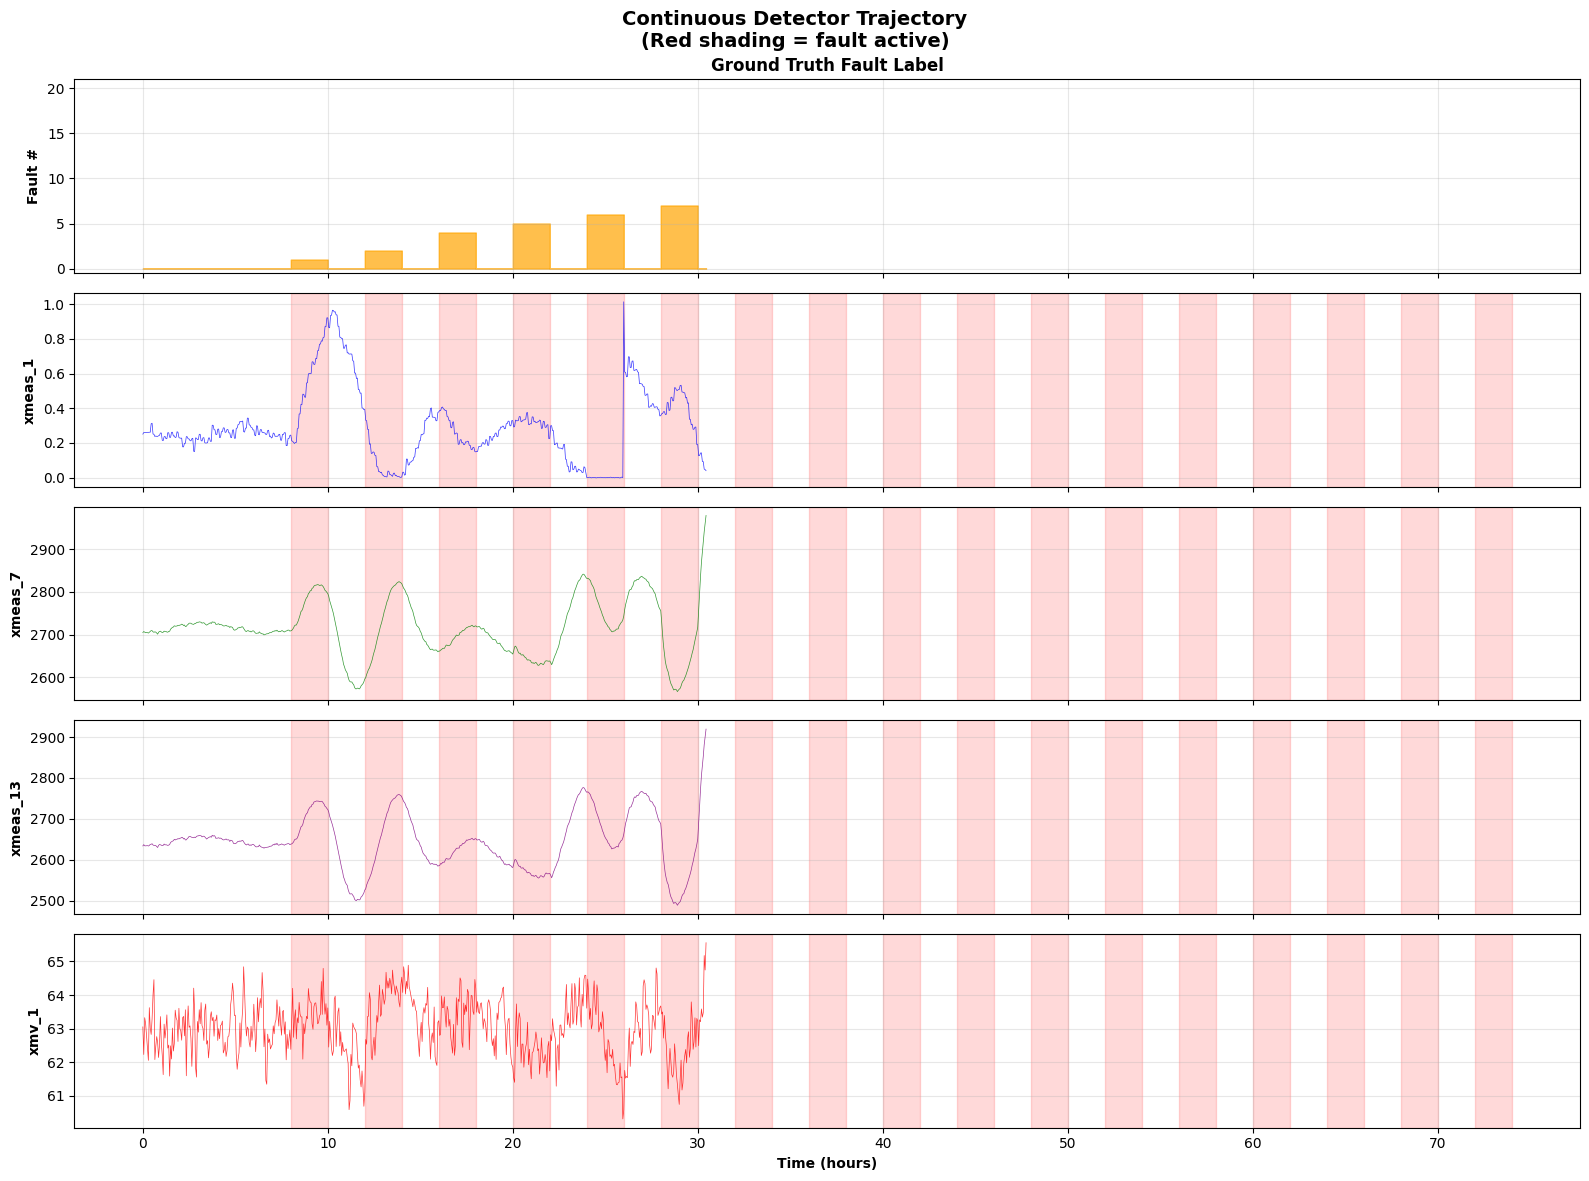


Visual inspection: Transitions should be smooth, not sudden jumps.
Faults should gradually affect measurements, then recover smoothly.


In [7]:
import matplotlib.pyplot as plt

# Visualize trajectory to confirm continuity
fig, axes = plt.subplots(5, 1, figsize=(16, 12), sharex=True)

# Plot ground truth at top
ax = axes[0]
ax.fill_between(df['time_hours'], df['faultNumber'], alpha=0.7, color='orange', step='post')
ax.set_ylabel('Fault #', fontweight='bold')
ax.set_ylim(-0.5, max(FAULT_CLASSES) + 1)
ax.grid(alpha=0.3)
ax.set_title('Ground Truth Fault Label', fontweight='bold')

# Plot key features
features = ['xmeas_1', 'xmeas_7', 'xmeas_13', 'xmv_1']
colors = ['blue', 'green', 'purple', 'red']

for ax, feature, color in zip(axes[1:], features, colors):
    ax.plot(df['time_hours'], df[feature], color=color, linewidth=0.5, alpha=0.8)
    ax.set_ylabel(feature, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Mark fault periods with shading
    for start, end, fault in ground_truth_periods:
        if fault != 0:
            ax.axvspan(start, end, alpha=0.15, color='red')

axes[-1].set_xlabel('Time (hours)', fontweight='bold')

plt.suptitle('Continuous Detector Trajectory\n(Red shading = fault active)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nVisual inspection: Transitions should be smooth, not sudden jumps.")
print("Faults should gradually affect measurements, then recover smoothly.")

## Save Trajectory

In [8]:
print("\nSaving trajectory...")

# Save main trajectory file
output_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}.csv'
df.to_csv(output_file, index=False)
file_size_mb = output_file.stat().st_size / 1e6
print(f"Saved to {output_file} ({file_size_mb:.2f} MB)")

# Save metadata as JSON
info = {
    'quick_mode': QUICK_MODE,
    'total_hours': TOTAL_HOURS,
    'total_samples': n_samples,
    'normal_hours': NORMAL_HOURS,
    'fault_on_hours': FAULT_ON_HOURS,
    'fault_off_hours': FAULT_OFF_HOURS,
    'record_interval_seconds': RECORD_INTERVAL,
    'samples_per_fault': int(FAULT_ON_HOURS * SAMPLES_PER_HOUR),
    'samples_per_recovery': int(FAULT_OFF_HOURS * SAMPLES_PER_HOUR),
    'fault_classes': FAULT_CLASSES,
    'seed': SEED,
    'continuous_simulation': True,
    'ground_truth_periods': [
        {'start_hours': float(s), 'end_hours': float(e), 'fault_class': int(f)}
        for s, e, f in ground_truth_periods
    ],
    'schedule': [
        {'time_hours': float(t), 'action': a, 'fault_id': int(f)}
        for t, a, f in schedule
    ]
}

info_file = DATA_DIR / f'detector_trajectory{FILE_SUFFIX}_info.json'
with open(info_file, 'w') as f:
    json.dump(info, f, indent=2)
print(f"Saved metadata to {info_file}")


Saving trajectory...
Saved to ../data/detector_trajectory.csv (0.61 MB)
Saved metadata to ../data/detector_trajectory_info.json


In [9]:
print("\n" + "="*65)
print("Detector Trajectory Generation Complete!")
if QUICK_MODE:
    print("(Quick mode)")
print("="*65)

print(f"\nSimulation Details:")
print(f"  Type: CONTINUOUS (single run, full state continuity)")
print(f"  Duration: {TOTAL_HOURS} hours")
print(f"  Total samples: {n_samples:,}")

print(f"\nFault Testing:")
print(f"  Faults tested: {len(FAULT_CLASSES)} types")
print(f"  Fault ON duration: {FAULT_ON_HOURS} hours ({int(FAULT_ON_HOURS * SAMPLES_PER_HOUR)} samples each)")
print(f"  Recovery duration: {FAULT_OFF_HOURS} hours ({int(FAULT_OFF_HOURS * SAMPLES_PER_HOUR)} samples each)")

print(f"\nSample Distribution:")
print(f"  Normal/recovery samples: {(df['faultNumber'] == 0).sum():,}")
print(f"  Fault samples: {(df['faultNumber'] != 0).sum():,}")

print(f"\nAdvantages of Continuous Simulation:")
print(f"  - Faults emerge from steady-state (realistic onset)")
print(f"  - No initialization transients between segments")
print(f"  - Recovery dynamics show actual process stabilization")
print(f"  - Matches how training data was generated")
print(f"  - Sequence models see meaningful temporal context")

print(f"\nOutput files:")
print(f"  - {output_file}")
print(f"  - {info_file}")
print("="*65)


Detector Trajectory Generation Complete!

Simulation Details:
  Type: CONTINUOUS (single run, full state continuity)
  Duration: 76 hours
  Total samples: 610

Fault Testing:
  Faults tested: 17 types
  Fault ON duration: 2 hours (40 samples each)
  Recovery duration: 2 hours (40 samples each)

Sample Distribution:
  Normal/recovery samples: 370
  Fault samples: 240

Advantages of Continuous Simulation:
  - Faults emerge from steady-state (realistic onset)
  - No initialization transients between segments
  - Recovery dynamics show actual process stabilization
  - Matches how training data was generated
  - Sequence models see meaningful temporal context

Output files:
  - ../data/detector_trajectory.csv
  - ../data/detector_trajectory_info.json
